In [1]:
pip install xgboost


  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/43/80/0b5a2dfcf5b4da27b0b68d2833f05d77e1a374d43db951fca200a1f12a52/xgboost-2.1.4-py3-none-win_amd64.whl.metadata
  Using cached xgboost-2.1.4-py3-none-win_amd64.whl.metadata (2.1 kB)
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/124.9 MB 440.4 kB/s eta 0:04:44
   ---------------------------------------- 0.1/124.9 MB 819.2 kB/s eta 0:02:33
   ---------------------------------------- 0.2/124.9 MB 958.1 kB/s eta 0:02:11
   ---------------------------------------- 0.3/124.9 MB 1.3 MB/s eta 0:01:39
   ---------------------------------------- 0.3/124.9 MB 1.2 MB/s eta 0:01:41
   ---------------------------------------- 0.4/124.9 MB 1.2 MB/s eta 0:01:48
   ---------------------------------------- 0.4/124.9 MB 1.1 MB/s eta 0:01:55
   ---------------------------

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb 
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA

In [3]:
pip install prophet

  Obtaining dependency information for prophet from https://files.pythonhosted.org/packages/12/ff/a04156f4ca3d18bd005c73f79e86e0684346fbc2aea856429c3e49f2828e/prophet-1.1.6-py3-none-win_amd64.whl.metadata
  Obtaining dependency information for cmdstanpy>=1.0.4 from https://files.pythonhosted.org/packages/2a/80/04b3989f055e555737b3b6944f02112e90cfc4f2e53c763771dded22e684/cmdstanpy-1.2.5-py3-none-any.whl.metadata
  Obtaining dependency information for holidays<1,>=0.25 from https://files.pythonhosted.org/packages/0b/32/740b50bb81d0bbf16b22037224ee23491d1f76eca2479be7f472a7e28c20/holidays-0.68-py3-none-any.whl.metadata
  Obtaining dependency information for importlib-resources from https://files.pythonhosted.org/packages/a4/ed/1f1afb2e9e7f38a545d628f864d562a5ae64fe6f7a10e28ffb9b185b4e89/importlib_resources-6.5.2-py3-none-any.whl.metadata
  Obtaining dependency information for stanio<2.0.0,>=0.4.0 from https://files.pythonhosted.org/packages/56/87/37a80e4d5bd453c33262d8fb618b6840fd98d24ed0

In [5]:
try:
    from prophet import Prophet  # Updated import for Prophet
except ImportError:
    Prophet = None  # Handle case where Prophet is not installed

In [7]:
# Load dataset
df = pd.read_csv("Reliance.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-11-18,463.799988,465.649994,454.975006,456.000000,436.671021,5142766.0
1,2015-11-19,459.450012,469.350006,458.625000,467.375000,447.563873,5569752.0
2,2015-11-20,467.000000,476.399994,462.774994,473.424988,453.357422,5167930.0
3,2015-11-23,475.000000,478.950012,473.100006,476.875000,456.661224,4800026.0
4,2015-11-24,476.500000,485.799988,475.524994,483.850006,463.340515,6768886.0


In [8]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[['Close']]
df

,Close
Date,
2015-11-18,456.000000
2015-11-19,467.375000
2015-11-20,473.424988
2015-11-23,476.875000
2015-11-24,483.850006
...,...
2020-11-10,2084.550049
2020-11-11,1997.199951
2020-11-12,1980.000000


In [9]:
df.shape

(1233, 1)

In [10]:
df.describe()

,Close
count,1232.000000
mean,1035.164502
std,462.301697
min,453.274994
25%,553.049988
50%,960.949982
75%,1308.337494
max,2324.550049


In [11]:
# Handle missing values
df.dropna(inplace=True)

In [12]:
# Normalize data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

In [13]:
# Prepare data for LSTM
seq_length = 60
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

X, y = create_sequences(df_scaled, seq_length)
X_train, y_train = X[:-365], y[:-365]
X_test, y_test = X[-365:], y[-365:]

In [14]:
# Build LSTM model
model = Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(seq_length, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=16)

C:\Users\aajjm\anaconda4\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 0.0134
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0011
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0011
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 6.9949e-04
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 7.0698e-04
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 6.1766e-04
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 6.4788e-04
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 7.6351e-04
Epoch 9/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 6.4592e-04
Epoch 10/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 5.3990e-04
Epoch 11/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 5.2387e-04
Epoch 12/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 4.4842e-04
Epoch 13/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 4.4339e-04
Epoch 14/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 4.6252e-04
Epoch 15/50
51/51 ━━━━━━━━

In [15]:
# Predict next 365 days
predictions = []
last_seq = X_test[-1]
for _ in range(365):
    pred = model.predict(last_seq.reshape(1, seq_length, 1))
    predictions.append(pred[0, 0])
    last_seq = np.roll(last_seq, -1)
    last_seq[-1] = pred[0, 0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━

In [16]:
# Inverse transform predictions
lstm_predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

In [17]:
# XGBoost Model
XGB = XGBRegressor(n_estimators=100, learning_rate=0.1)
XGB.fit(np.arange(len(df)).reshape(-1, 1), df['Close'])
xgb_predictions = XGB.predict(np.arange(len(df), len(df) + 365).reshape(-1, 1))

In [18]:
# ARIMA Model
arima_model = ARIMA(df['Close'], order=(5, 1, 0))
arima_fit = arima_model.fit()
arima_predictions = arima_fit.forecast(steps=365)

C:\Users\aajjm\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\aajjm\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\aajjm\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\aajjm\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\U

In [19]:
# Prophet Model (if installed)
if Prophet:
    df_prophet = df.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
    prophet = Prophet()
    prophet.fit(df_prophet)
    future = prophet.make_future_dataframe(periods=365)
    prophet_predictions = prophet.predict(future)['yhat'].iloc[-365:]
else:
    prophet_predictions = None

14:30:22 - cmdstanpy - INFO - Chain [1] start processing
14:30:23 - cmdstanpy - INFO - Chain [1] done processing


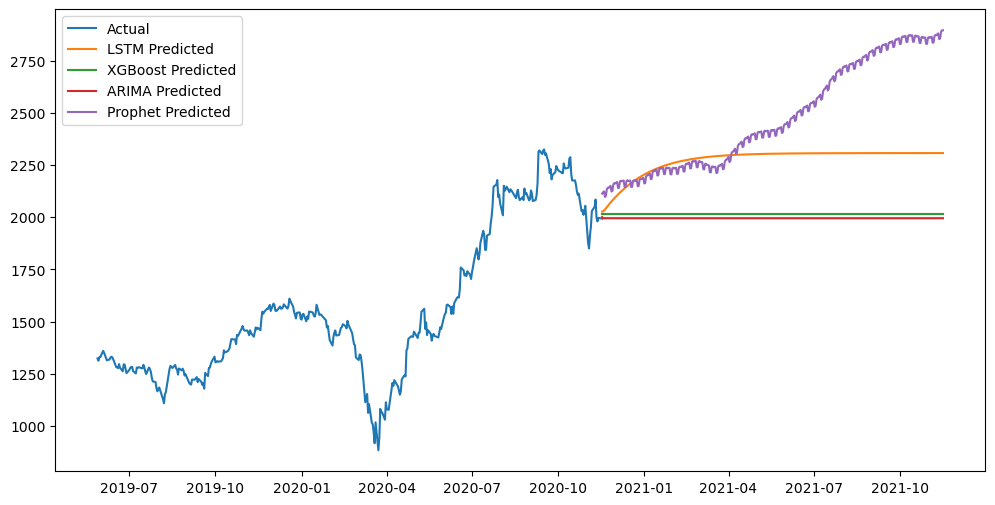

In [20]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(df.index[-365:], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual')
plt.plot(pd.date_range(df.index[-1], periods=365, freq='D'), lstm_predictions, label='LSTM Predicted')
plt.plot(pd.date_range(df.index[-1], periods=365, freq='D'), xgb_predictions, label='XGBoost Predicted')
plt.plot(pd.date_range(df.index[-1], periods=365, freq='D'), arima_predictions, label='ARIMA Predicted')
if prophet_predictions is not None:
    plt.plot(pd.date_range(df.index[-1], periods=365, freq='D'), prophet_predictions, label='Prophet Predicted')
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Inverse transform test data
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compute Errors
lstm_mae = mean_absolute_error(y_test_actual, lstm_predictions)
lstm_rmse = mean_squared_error(y_test_actual, lstm_predictions, squared=False)

xgb_mae = mean_absolute_error(y_test_actual, xgb_predictions[:len(y_test_actual)])
xgb_rmse = mean_squared_error(y_test_actual, xgb_predictions[:len(y_test_actual)], squared=False)

arima_mae = mean_absolute_error(y_test_actual, arima_predictions[:len(y_test_actual)])
arima_rmse = mean_squared_error(y_test_actual, arima_predictions[:len(y_test_actual)], squared=False)

if prophet_predictions is not None:
    prophet_mae = mean_absolute_error(y_test_actual, prophet_predictions[:len(y_test_actual)])
    prophet_rmse = mean_squared_error(y_test_actual, prophet_predictions[:len(y_test_actual)], squared=False)
else:
    prophet_mae, prophet_rmse = None, None

# Print Results
print("Model Performance Comparison:")
print(f"LSTM - MAE: {lstm_mae:.4f}, RMSE: {lstm_rmse:.4f}")
print(f"XGBoost - MAE: {xgb_mae:.4f}, RMSE: {xgb_rmse:.4f}")
print(f"ARIMA - MAE: {arima_mae:.4f}, RMSE: {arima_rmse:.4f}")

if prophet_mae is not None:
    print(f"Prophet - MAE: {prophet_mae:.4f}, RMSE: {prophet_rmse:.4f}")

# Find the best model based on RMSE
errors = {
    "LSTM": lstm_rmse,
    "XGBoost": xgb_rmse,
    "ARIMA": arima_rmse
}
if prophet_rmse is not None:
    errors["Prophet"] = prophet_rmse

best_model = min(errors, key=errors.get)
print(f"\nBest model based on RMSE: {best_model}")


Model Performance Comparison:
LSTM - MAE: 704.1346, RMSE: 778.2191
XGBoost - MAE: 502.2984, RMSE: 568.7652
ARIMA - MAE: 490.3996, RMSE: 553.1995
Prophet - MAE: 906.2182, RMSE: 928.6639

Best model based on RMSE: ARIMA
